In [1]:
!apt install sox

Reading package lists... Done
Building dependency tree       
Reading state information... Done
sox is already the newest version (14.4.2-3ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


### Baseline commands recognition (2-5 points)

We're now going to train a classifier to recognize voice. More specifically, we'll use the [Speech Commands Dataset] that contains around 30 different words with a few thousand voice records each.

In [2]:
import os
from IPython.display import display, Audio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import librosa
import torch
from torch.utils.data import TensorDataset, DataLoader

datadir = "speech_commands"

!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# alternative url: https://www.dropbox.com/s/j95n278g48bcbta/speech_commands_v0.01.tar.gz?dl=1
!mkdir {datadir} && tar -C {datadir} -xvzf speech_commands_v0.01.tar.gz 1> log

samples_by_target = {
    cls: [os.path.join(datadir, cls, name) for name in os.listdir("./speech_commands/{}".format(cls))]
    for cls in os.listdir(datadir)
    if os.path.isdir(os.path.join(datadir, cls))
}
print('Classes:', ', '.join(sorted(samples_by_target.keys())[1:]))

--2021-10-26 20:06:50--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.212.128, 2607:f8b0:4001:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.212.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   225MB/s    in 6.3s    

2021-10-26 20:06:56 (227 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

mkdir: cannot create directory ‘speech_commands’: File exists
Classes: bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, wow, yes, zero


In [3]:
!sox --info speech_commands/bed/00176480_nohash_0.wav


Input File     : 'speech_commands/bed/00176480_nohash_0.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:01.00 = 16000 samples ~ 75 CDDA sectors
File Size      : 32.0k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM



In [4]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm
import joblib as jl

classes = ("left", "right", "up", "down", "stop")

def preprocess_sample(filepath, max_length=124):
    amplitudes, sr = librosa.core.load(filepath)
    spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = classes.index(filepath.split(os.sep)[-2])
    return np.float32(spectrogram), np.int64(target)

all_files = chain(*(samples_by_target[cls] for cls in classes))
spectrograms_and_targets = jl.Parallel(n_jobs=-1)(tqdm(list(map(jl.delayed(preprocess_sample), all_files))))
X, y = map(np.stack, zip(*spectrograms_and_targets))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

100%|██████████| 11834/11834 [07:51<00:00, 25.11it/s]


In [5]:
batch_size = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tensor_x = torch.Tensor(X_train)
tensor_y = torch.LongTensor(y_train)

train_dataset = TensorDataset(tensor_x, tensor_y)

tensor_x = torch.Tensor(X_test) # transform to torch tensor
tensor_y = torch.LongTensor(y_test)

test_dataset = TensorDataset(tensor_x, tensor_y)


trainloader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2)

In [6]:
X_train.shape

(8875, 124, 128)

In [7]:
print(f"Размерность одного примера: {train_dataset[0][0].shape}")
print(f"Классы, на которые мы будем делать классификацию: {set(map(int, train_dataset[:][1]))}")

Размерность одного примера: torch.Size([124, 128])
Классы, на которые мы будем делать классификацию: {0, 1, 2, 3, 4}


### Реализуем модель из статьи MatchboxNet: 1D Time-Channel Separable Convolutional Neural Network Architecture for Speech Commands Recognition

source: https://arxiv.org/pdf/2004.08531.pdf

Будем реализовывать $MatchboxNet-3x2x64$

In [4]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class TCSConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, padding=0):
        """
        Реализация 1D-time-channel separable convolution
        """
        super(TCSConv1d, self).__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, 
                                stride=stride, dilation=dilation, padding=padding,
                                groups=in_channels)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class MatchboxNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # prologue
        self.prolog = nn.Sequential(
            TCSConv1d(in_channels=128, out_channels=64, kernel_size=11, stride=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        # block1
        self.block1_conv1 = TCSConv1d(in_channels=64, out_channels=64, kernel_size=13, padding=6)
        self.block1_batchnorm1 = nn.BatchNorm1d(64)
        self.block1_conv2 = TCSConv1d(in_channels=64, out_channels=64, kernel_size=13, padding=6)
        self.block1_batchnorm2 = nn.BatchNorm1d(64)
        self.block1_pointwise_conv = nn.Conv1d(64, 64, kernel_size=1)
        self.block1_batchnorm3 = nn.BatchNorm1d(64)

        # block2
        self.block2_conv1 = TCSConv1d(in_channels=64, out_channels=64, kernel_size=15, padding=7)
        self.block2_batchnorm1 = nn.BatchNorm1d(64)
        self.block2_conv2 = TCSConv1d(in_channels=64, out_channels=64, kernel_size=15, padding=7)
        self.block2_batchnorm2 = nn.BatchNorm1d(64)
        self.block2_pointwise_conv = nn.Conv1d(64, 64, kernel_size=1)
        self.block2_batchnorm3 = nn.BatchNorm1d(64)

        # block3
        self.block3_conv1 = TCSConv1d(in_channels=64, out_channels=64, kernel_size=17, padding=8)
        self.block3_batchnorm1 = nn.BatchNorm1d(64)
        self.block3_conv2 = TCSConv1d(in_channels=64, out_channels=64, kernel_size=17, padding=8)
        self.block3_batchnorm2 = nn.BatchNorm1d(64)
        self.block3_pointwise_conv = nn.Conv1d(64, 64, kernel_size=1)
        self.block3_batchnorm3 = nn.BatchNorm1d(64)

        # epilogue
        self.epilog1 = nn.Sequential(
            TCSConv1d(in_channels=64, out_channels=128, kernel_size=29, dilation=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.epilog2 = nn.Sequential(
            TCSConv1d(in_channels=128, out_channels=128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.epilog3 = nn.Conv1d(128, num_classes, kernel_size=1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        # x: [batch, time, channels]
        # x: [batch, 124, 128]
        batch, time, channels = x.shape
        x = x.permute(0, 2, 1)

        # prologue conv1
        # conv1 kernel_size=11
        x = self.prolog(x)

        res_block1 = x

        # block 1 kernel_size=13
        res_x_1 = self.block1_batchnorm3(self.block1_pointwise_conv(x))
        x = self.dropout(self.relu(self.block1_batchnorm1(self.block1_conv1(x))))
        x = self.block1_batchnorm2(self.block1_conv2(x))
        x = x + res_x_1
        x = self.dropout(self.relu(x))

        # residual connection
        x = x + res_block1
        res_block2 = x

        # block 2 kernel_size=15
        res_x_2 = self.block2_batchnorm3(self.block2_pointwise_conv(x))
        x = self.dropout(self.relu(self.block2_batchnorm1(self.block2_conv1(x))))
        x = self.block2_batchnorm2(self.block2_conv2(x))
        x = x + res_x_2
        x = self.dropout(self.relu(x))

        # residual connection
        x = x + res_block2
        res_block3 = x

        # block 3 kernel_size=17
        res_x_3 = self.block3_batchnorm3(self.block3_pointwise_conv(x))
        x = self.dropout(self.relu(self.block3_batchnorm1(self.block3_conv1(x))))
        x = self.block3_batchnorm2(self.block3_conv2(x))
        x = x + res_x_3
        x = self.dropout(self.relu(x))

        # residual connection
        x = x + res_block3

        # epilogue conv2->conv3->conv4
        # conv2 kernel_size=29 dilation=2
        x = self.epilog1(x)
        # conv3 kernel_size=1
        x = self.epilog2(x)
        # conv4 kernel_size=1
        x = self.epilog3(x)

        x = self.flatten(x)
        
        x = F.softmax(x)

        return x


net = MatchboxNet(num_classes=5).to(device)

In [5]:
from torchsummary import summary

summary(net, (124, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 128, 57]           1,536
            Conv1d-2               [-1, 64, 57]           8,256
         TCSConv1d-3               [-1, 64, 57]               0
       BatchNorm1d-4               [-1, 64, 57]             128
              ReLU-5               [-1, 64, 57]               0
           Dropout-6               [-1, 64, 57]               0
            Conv1d-7               [-1, 64, 57]           4,160
       BatchNorm1d-8               [-1, 64, 57]             128
            Conv1d-9               [-1, 64, 57]             896
           Conv1d-10               [-1, 64, 57]           4,160
        TCSConv1d-11               [-1, 64, 57]               0
      BatchNorm1d-12               [-1, 64, 57]             128
             ReLU-13               [-1, 64, 57]               0
          Dropout-14               [-1,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


### Замечания, которые у меня есть по модели. Первое, что я долго не мог понять, это то, что блоки не изменяют длину временной размерности (кроме блоков prologue и epilogue). Я не мог этого понять, потому что в статье ни слова не написано об использовании паддинга в separable свертках. Это стало очевидно, когда я вспомнил о том, что в модели используются skip connection'ы - выход из блока складывается с его входом. Поэтому свертки не должны менять размерность данных. Поэтому для сверток должен быть использован same padding, которого нет в pytorch и нужно подбирать руками. Я подобрал паддинги для блоков, чтобы не менялась размерность и реализовал все, как описано в статье. Но единственное, что у меня не сошлось с ней, это то что у них временная размерность 128, а у меня 124 (если взять 128, то после последнего слоя будет размерность не 1, а 3). Возможно я где-то ошибся, или не так понял статью. Но у меня все работает так. Количество параметров у меня вышло меньше, чем заявленное: заявлено в статье - 93к, а у меня вышло - 83к.  

In [6]:
L_in = 57
dilation = 2
kernel_size = 29
stride = 1
padding = 0
L_out = int(np.floor((L_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1))
L_out

1

In [35]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [36]:
from tqdm import tqdm

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
107it [00:03, 36.43it/s]

[1,   100] loss: 1.611


207it [00:05, 35.82it/s]

[1,   200] loss: 1.609


307it [00:08, 34.34it/s]

[1,   300] loss: 1.604


407it [00:11, 34.47it/s]

[1,   400] loss: 1.598


503it [00:14, 33.79it/s]

[1,   500] loss: 1.579


555it [00:16, 34.19it/s]
104it [00:03, 35.32it/s]

[2,   100] loss: 1.521


204it [00:05, 34.31it/s]

[2,   200] loss: 1.508


304it [00:08, 35.70it/s]

[2,   300] loss: 1.487


404it [00:11, 34.34it/s]

[2,   400] loss: 1.471


504it [00:14, 35.61it/s]

[2,   500] loss: 1.453


555it [00:16, 34.65it/s]
104it [00:03, 34.84it/s]

[3,   100] loss: 1.408


204it [00:05, 34.52it/s]

[3,   200] loss: 1.413


304it [00:08, 32.73it/s]

[3,   300] loss: 1.390


404it [00:11, 34.92it/s]

[3,   400] loss: 1.379


504it [00:14, 32.57it/s]

[3,   500] loss: 1.378


555it [00:16, 33.96it/s]
107it [00:03, 34.98it/s]

[4,   100] loss: 1.331


203it [00:05, 33.08it/s]

[4,   200] loss: 1.352


303it [00:08, 34.29it/s]

[4,   300] loss: 1.345


403it [00:11, 33.66it/s]

[4,   400] loss: 1.334


507it [00:14, 35.02it/s]

[4,   500] loss: 1.325


555it [00:16, 34.05it/s]
106it [00:03, 35.18it/s]

[5,   100] loss: 1.326


207it [00:06, 35.95it/s]

[5,   200] loss: 1.301


307it [00:08, 34.51it/s]

[5,   300] loss: 1.276


407it [00:11, 34.02it/s]

[5,   400] loss: 1.291


503it [00:14, 32.75it/s]

[5,   500] loss: 1.287


555it [00:16, 33.82it/s]
103it [00:03, 33.00it/s]

[6,   100] loss: 1.287


203it [00:05, 33.54it/s]

[6,   200] loss: 1.267


303it [00:08, 33.69it/s]

[6,   300] loss: 1.259


403it [00:11, 34.84it/s]

[6,   400] loss: 1.253


503it [00:14, 33.34it/s]

[6,   500] loss: 1.267


555it [00:16, 34.10it/s]
107it [00:03, 35.38it/s]

[7,   100] loss: 1.258


203it [00:05, 33.68it/s]

[7,   200] loss: 1.248


307it [00:08, 35.55it/s]

[7,   300] loss: 1.243


407it [00:11, 34.75it/s]

[7,   400] loss: 1.235


507it [00:14, 33.68it/s]

[7,   500] loss: 1.249


555it [00:16, 34.21it/s]
107it [00:03, 34.37it/s]

[8,   100] loss: 1.215


207it [00:06, 35.16it/s]

[8,   200] loss: 1.229


303it [00:08, 33.69it/s]

[8,   300] loss: 1.233


403it [00:11, 32.62it/s]

[8,   400] loss: 1.243


503it [00:14, 34.77it/s]

[8,   500] loss: 1.227


555it [00:16, 33.99it/s]
107it [00:03, 36.16it/s]

[9,   100] loss: 1.222


207it [00:06, 33.93it/s]

[9,   200] loss: 1.200


307it [00:09, 34.98it/s]

[9,   300] loss: 1.210


403it [00:11, 33.95it/s]

[9,   400] loss: 1.207


503it [00:14, 32.39it/s]

[9,   500] loss: 1.201


555it [00:16, 33.88it/s]
103it [00:03, 32.55it/s]

[10,   100] loss: 1.193


203it [00:06, 32.26it/s]

[10,   200] loss: 1.210


303it [00:09, 32.28it/s]

[10,   300] loss: 1.201


403it [00:12, 33.01it/s]

[10,   400] loss: 1.195


507it [00:15, 33.57it/s]

[10,   500] loss: 1.194


555it [00:16, 33.30it/s]

Finished Training


Train a model: finally, lets' build and train a classifier neural network. You can use any library you like. If in doubt, consult the model & training tips below.

__Training tips:__ here's what you can try:
* __Layers:__ 1d or 2d convolutions, perhaps with some batch normalization in between;
* __Architecture:__ VGG-like, residual, highway, densely-connected, MatchboxNet, Dilated convs - you name it :)
* __Batch size matters:__ smaller batches usually train slower but better. Try to find the one that suits you best.
* __Data augmentation:__ add background noise, faster/slower, change pitch;
* __Average checkpoints:__ you can make model more stable with [this simple technique (arxiv)](https://arxiv.org/abs/1803.05407)
* __For full scale stage:__ make sure you're not losing too much data due to max_length in the pre-processing stage!

These are just recommendations. As long as your model works, you're not required to follow them.

### Full scale commands recognition (3+ points)

Your final task is to train a full-scale voice command spotter and apply it to a video:
1. Build the dataset with all 30+ classes (directions, digits, names, etc.)
  * __Optional:__ include a special "noise" class that contains random unrelated sounds
  * You can download youtube videos with [`youtube-dl`](https://ytdl-org.github.io/youtube-dl/index.html) library.
2. Train a model on this full dataset. Kudos for tuning its accuracy :)
3. Apply it to a audio/video of your choice to spot the occurences of each keyword
 * Here's one [video about primes](https://www.youtube.com/watch?v=EK32jo7i5LQ) that you can try. It should be full of numbers :)
 * There are multiple ways you can analyze the performance of your network, e.g. plot probabilities predicted for every time-step. Chances are you'll discover something useful about how to improve your model :)


Please briefly describe what you did in a short informal report.

### Весь датасет упал с OOM, поэтому загрузим поменьше

In [ ]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm
import joblib as jl

classes = ("five", "four", "nine", "two", "bird")

def preprocess_sample(filepath, max_length=124):
    amplitudes, sr = librosa.core.load(filepath)
    spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = classes.index(filepath.split(os.sep)[-2])
    return np.float32(spectrogram), np.int64(target)

all_files = chain(*(samples_by_target[cls] for cls in classes))
spectrograms_and_targets = jl.Parallel(n_jobs=-1)(tqdm(list(map(jl.delayed(preprocess_sample), all_files))))
X, y = map(np.stack, zip(*spectrograms_and_targets))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
batch_size = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tensor_x = torch.Tensor(X_train)
tensor_y = torch.LongTensor(y_train)

train_dataset = TensorDataset(tensor_x, tensor_y)

tensor_x = torch.Tensor(X_test) # transform to torch tensor
tensor_y = torch.LongTensor(y_test)

test_dataset = TensorDataset(tensor_x, tensor_y)


trainloader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2)

In [15]:
import torch.optim as optim

net = MatchboxNet(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [16]:
from tqdm.notebook import tqdm

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   500] loss: 1.499


0it [00:00, ?it/s]

[2,   500] loss: 1.314


0it [00:00, ?it/s]

[3,   500] loss: 1.298


0it [00:00, ?it/s]

[4,   500] loss: 1.279


0it [00:00, ?it/s]

[5,   500] loss: 1.242


0it [00:00, ?it/s]

[6,   500] loss: 1.207


0it [00:00, ?it/s]

[7,   500] loss: 1.195


0it [00:00, ?it/s]

[8,   500] loss: 1.184


0it [00:00, ?it/s]

[9,   500] loss: 1.178


0it [00:00, ?it/s]

[10,   500] loss: 1.164
Finished Training


### Хочется скачать видео про птиц (не очень длинное) и посмотреть на график вероятностей предсказания слова bird

Хороший вариант: https://www.youtube.com/watch?v=Mu6b3u_95Ts

In [17]:
!pip install youtube_dl

     |████████████████████████████████| 1.9 MB 5.4 MB/s 


In [19]:
from __future__ import unicode_literals
import youtube_dl

ydl_opts = {
    'format': 'bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'wav',
        'preferredquality': '256'
    }],
    'postprocessor_args': [
        '-ar', '16000',
        '-ac', '1'
        
    ],
    'prefer_ffmpeg': True,
    'keepvideo': True
    
}

with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download(['https://www.youtube.com/watch?v=Mu6b3u_95Ts'])

[youtube] Mu6b3u_95Ts: Downloading webpage
[download] Destination: Interesting Facts about Birds _ Educational Video for Kids.-Mu6b3u_95Ts.webm
[download] 100% of 3.58MiB in 00:43
[ffmpeg] Destination: Interesting Facts about Birds _ Educational Video for Kids.-Mu6b3u_95Ts.wav


In [23]:
import joblib as jl

def preprocess_sample(filepath):
    amplitudes, sr = librosa.core.load(filepath)
    spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr)
    return np.float32(spectrogram)

In [24]:
spectrogram = preprocess_sample('Interesting Facts about Birds _ Educational Video for Kids.-Mu6b3u_95Ts.wav')

  1%|          | 248/25397 [18:36<31:26:16,  4.50s/it]


In [31]:
parts = []

for i in range(0, spectrogram.shape[1]-124, 10):
    parts.append(spectrogram[:, i:i + 124])

parts = np.float32(parts)
parts = parts.transpose([0, 2, 1])
parts = parts[:, None, :, :]

batch_size = 64
tensor_video = torch.Tensor(parts)
video_dataset = TensorDataset(tensor_video)
videoloader = DataLoader(video_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4, drop_last=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [37]:
global_time = 0
probabilities = list()

with torch.no_grad():
    net.eval()
    for inputs in videoloader:
        inputs = inputs[0].to(device)
        inputs = inputs.reshape(64, 124, 128)
        outputs = net(inputs)
        probabilities = probabilities + list(map(float, outputs[:, 4]))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [55]:
# видео длится 3.31
print(len(probabilities))
x = np.array(list(range(896))) * 3.31 / 896

896


### Вероятность предсказания слова bird. Посмотрел видео, и это похоже на правду)

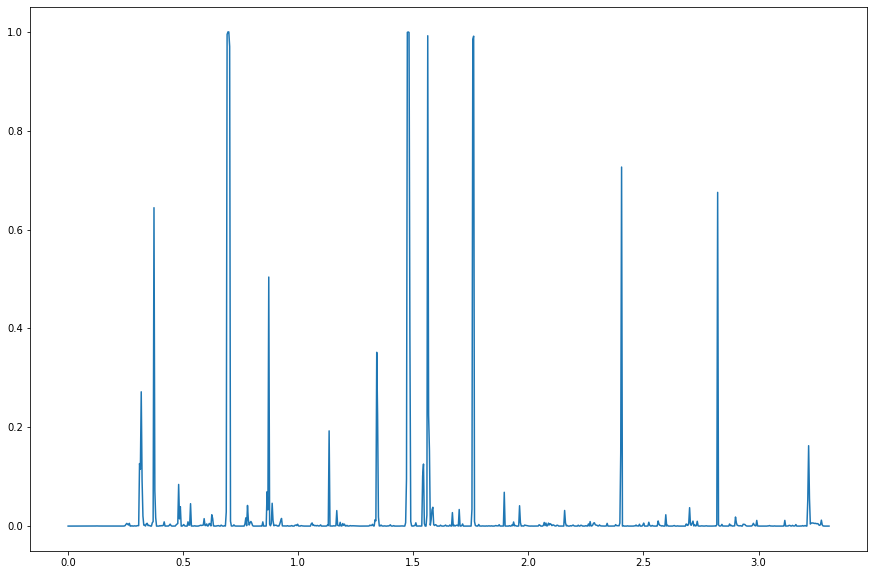

In [54]:
plt.figure(figsize=(15, 10))
plt.plot(x, probabilities);

### Код по предобработке видео для предсказания по нему подсмотрел в пулл реквесте Ольги Борисовой. Спасибо ее коду за возможность посмотреть на результаты работы моей модели)